# Reproduce CheXNet: Explore Predictions

## Import other modules and pandas

In [1]:
from __future__ import print_function, division

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# image imports
from skimage import io, transform
from PIL import Image
import matplotlib.pyplot as plt

# general imports
import os
import time
from shutil import copyfile
from shutil import rmtree

# data science imports
import pandas as pd
import numpy as np
import csv

import random

import cxr_dataset as CXR
import cxp_dataset as CXP
import model_fz as M
import eval_model_fz as E

#suppress pytorch warnings about source code changes
import warnings
warnings.filterwarnings('ignore')

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print(torch.__version__)
print(torchvision.__version__)

Available GPU count:1
1.0.1.post2
0.2.2


## Test data import
Change CheXNet import on NIH data to import of CheXpert data

Available GPU count:1
Sample transformed image:


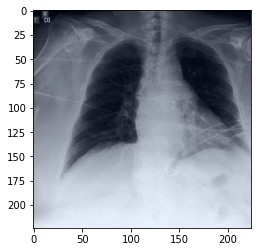

In [12]:
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0-small/"
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0/"

PATH_TO_IMAGES = "/home/frank_li_zhou/"

# use imagenet mean,std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# define torchvision transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224), # changed for pytorch 4.0.1
        # because scale doesn't always give 224 x 224, this ensures 224 x
        # 224
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# create train/val dataloaders
transformed_datasets = {}
transformed_datasets['train'] = CXP.CXPDataset(
    path_to_images=PATH_TO_IMAGES,
    path_to_csv=PATH_TO_CSV,
    fold='train',
    transform=data_transforms['train'],
)
transformed_datasets['val'] = CXP.CXPDataset(
    path_to_images=PATH_TO_IMAGES,
    path_to_csv=PATH_TO_CSV,
    fold='val',
    transform=data_transforms['val'],
)

#print(transformed_datasets['train'].df.iloc[1])
#print(transformed_datasets['train'][0][0].shape)
#print(transformed_datasets['val'][0][0].shape)

img = random.choice(transformed_datasets['train'])[0]
img = transformed_datasets['train'][0][0]
img -= img.min()
img /= img.max()

print("Sample transformed image:")
plt.imshow(img.permute(1, 2, 0))

In [ ]:
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0-small/"
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0/"
PATH_TO_IMAGES = "/home/frank_li_zhou/"

LOGGER = []

# adam
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.001

# # sgd
# WEIGHT_DECAY = 1e-4
# LEARNING_RATE = 0.01

preds, aucs = M.train_cnn(PATH_TO_IMAGES, PATH_TO_CSV, LEARNING_RATE, WEIGHT_DECAY, LOGGER)#NUM_IMAGES=100)


Available GPU count:1
Running with WD, LR: 0.0001 0.001
Uncertain labels are negative
Size of train set: 223414
Size of val set: 234
Model training start
Epoch 1/100
----------
train epoch 1: loss 0.3250 with data size 223414
train epoch complete in 143m 4s
val epoch 1: loss 0.4688 with data size 234
val epoch complete in 143m 13s
[[0.74188312]
 [0.69684621]
 [0.76933514]
 [0.7920047 ]
 [0.55016514]
 [       nan]
 [0.13304721]
 [0.82848325]
 [0.86761547]
 [0.80784699]
 [0.60515021]
 [0.47455752]
 [0.70464602]
 [0.71660902]]
mean epoch validation accuracy: 0.6683223077027836
saving checkpoint_1
best epoch:  1
best train loss:  0.32500639128172976
best val accuracy:  0.6683223077027836
Epoch 2/100
----------
train epoch 2: loss 0.3161 with data size 223414
train epoch complete in 283m 5s
val epoch 2: loss 0.4367 with data size 234
val epoch complete in 283m 14s
[[0.73733766]
 [0.73848335]
 [0.88391376]
 [0.82727807]
 [0.47229358]
 [       nan]
 [0.30472103]
 [0.87007643]
 [0.88104189]
 [

In [2]:
for line in LOGGER:
    print(line)

NameError: name 'LOGGER' is not defined

In [ ]:
import importlib

importlib.reload(CXP)
importlib.reload(CXR)
importlib.reload(M)
importlib.reload(E)

PATH_TO_MODEL = "/home/frank_li_zhou/reproduce-chexnet/pretrained/checkpoint"
PATH_TO_IMAGES = "/home/frank_li_zhou/"
PATH_TO_CSV = "/home/frank_li_zhou/CheXpert-v1.0-small/"

def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

checkpoint = torch.load(PATH_TO_MODEL, map_location=lambda storage, loc: storage)
model = checkpoint['model']
for i, (name, module) in enumerate(model._modules.items()):
    module = recursion_change_bn(model)

# put model on GPU
model = model.cuda()

# use imagenet mean,std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# define torchvision transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(224), # changed for pytorch 4.0.1
        # because scale doesn't always give 224 x 224, this ensures 224 x
        # 224
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

preds, metric = E.make_pred_multilabel(data_transforms, model, PATH_TO_IMAGES, PATH_TO_CSV, 'auc')

auc = metric.as_matrix(columns=metric.columns[1:])
print(auc[~np.isnan(auc)].mean())

In [9]:
print(metric)

NameError: name 'metric' is not defined